## Analyzing MD simulations
* https://projects.volkamerlab.org/teachopencadd/talktorials/T020_md_analysis.html

### TOC
* Load and visualize the system
* Alignment
* RMSD of protein and ligand
    * RMSD over time
    * RMSD between frames
* Interaction analysis
    * Atomic distances
    * Hydrogen bond analysis
        - Non-covalent interations like hydrogen bonds are key-players in the formation of a ligand-protein complex (PLoS One. (2010), 5(8), e12029, J. Med. Chem. 2010, 53(14), 5061-84). 

In [12]:
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nglview as nv
import MDAnalysis as mda
from MDAnalysis.analysis import rms, diffusionmap, align
from MDAnalysis.analysis.distances import dist
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA

In [13]:
result_dir = Path("./results/EGPR_tutorial")
Path(result_dir).mkdir(parents=True, exist_ok=True)

In [14]:
md_universe = mda.Universe(str(result_dir / "3POZ_03P_minimized.pdb"), str(result_dir / "3POZ_03P_3rd_trajectory.xtc"))
view = nv.show_mdanalysis(md_universe)
view

/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/topology/PDBParser.py:290: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


NGLWidget(max_frame=249)

In [15]:
view.render_image(trim=True, factor=2, transparent=True);
view._display_image()

In [16]:
# Align the trajectory to the protein
# Set trajectory pointer to first frame as reference
md_universe.trajectory[0]

# in_memory=True is needed to actually modify the loaded trajectory
# if the trajectory is too big for memory, one can write out the aligned trajectory and reload it into a new universe
alignment = align.AlignTraj(
    mobile=md_universe, reference=md_universe, select="protein", in_memory=True
)
alignment.run()

In [17]:
view = nv.show_mdanalysis(md_universe)
view

NGLWidget(max_frame=249)

In [18]:
view.render_image(trim=True, factor=2, transparent=True);
view._display_image()

In [19]:
# RMSD of protein and ligand
# To select ligand atoms, we can use the selection string "resname 03P"

ligand_name = "UNK" # since in the PDB file the ligand is named UNK
# TODO: check why the ligand is named UNK in the PDB file

In [20]:
def rmsd_for_atomgroups(universe, selection1, selection2=None):
    """Calulate the RMSD for selected atom groups.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection1: str
        Selection string for main atom group, also used during alignment.
    selection2: list of str, optional
        Selection strings for additional atom groups.

    Returns
    -------
    rmsd_df: pandas.core.frame.DataFrame
        DataFrame containing RMSD of the selected atom groups over time.
    """

    universe.trajectory[0]
    ref = universe
    rmsd_analysis = rms.RMSD(universe, ref, select=selection1, groupselections=selection2)
    rmsd_analysis.run()
    columns = [selection1, *selection2] if selection2 else [selection1]
    rmsd_df = pd.DataFrame(np.round(rmsd_analysis.results.rmsd[:, 2:], 2), columns=columns)
    rmsd_df.index.name = "frame"
    return rmsd_df

In [21]:
rmsd = rmsd_for_atomgroups(md_universe, "backbone", ["protein", f"resname {ligand_name}"])
rmsd.head()

,backbone,protein,resname UNK
frame,,,
0,0.00,0.00,0.00
1,0.76,0.93,0.98
2,0.80,1.02,1.22
3,0.89,1.13,1.25
4,0.91,1.19,1.29


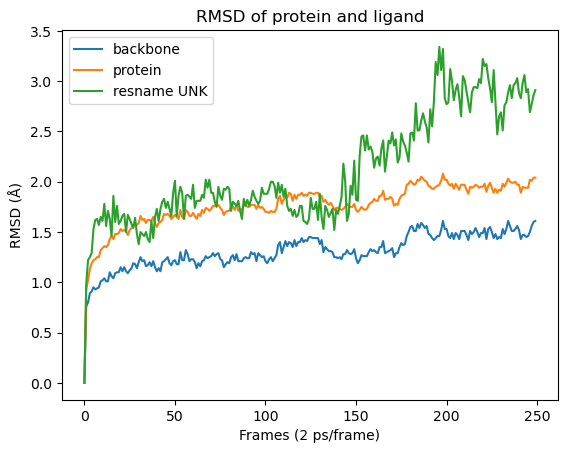

In [22]:
rmsd.plot(title="RMSD of protein and ligand")
plt.ylabel("RMSD (Å)");
plt.xlabel('Frames (2 ps/frame)');

#### What can we see in the plot:
* There are only slight conformational changes in the backbone during the simulation, which is not surprising since the protein was superimposed w.r.t. the backbone.
    * Bakbone means the protein backbone atoms (N, C, O, CA)
* Including the protein side chains in RMSD calculation lead to more movement, when compared to the protein backbone only.
    * Protein means the protein backbone atoms (N, C, O, CA) and the side chain atoms
* In our simulation the ligands movements are in the same range as the protein side chains. However, this is not always the case as the ligand can move more freely and, additionally to any conformational changes, there might be directional movement involved. This is likely the case if the RMSD values for the ligand are exceptionally high.


### Pairwise RMSD between frames
* We can calculate the RMSD between all frames of the simulation to get an idea of the conformational changes that occur during the simulation.
* Visualizing the RMSD matrix as a heatmap can give us an overview of the conformational changes that occur during the simulation.

In [23]:
def RMSD_dist_frames(universe, selection):
    """Calculate the RMSD between all frames in a matrix.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    selection: str
        Selection string for the atomgroup to be investigated, also used during alignment.

    Returns
    -------
    array: np.ndarray
        Numpy array of RMSD values.
    """
    pairwise_rmsd = diffusionmap.DistanceMatrix(universe, select=selection)
    pairwise_rmsd.run()
    return pairwise_rmsd.results.dist_matrix

In [24]:
dist_matrix_protein = RMSD_dist_frames(md_universe, "protein")
dist_matrix_ligand = RMSD_dist_frames(md_universe, f"resname {ligand_name}")

In [25]:
# get maximal distance between all frames
max_dist = max(np.amax(dist_matrix_ligand), np.amax(dist_matrix_protein))

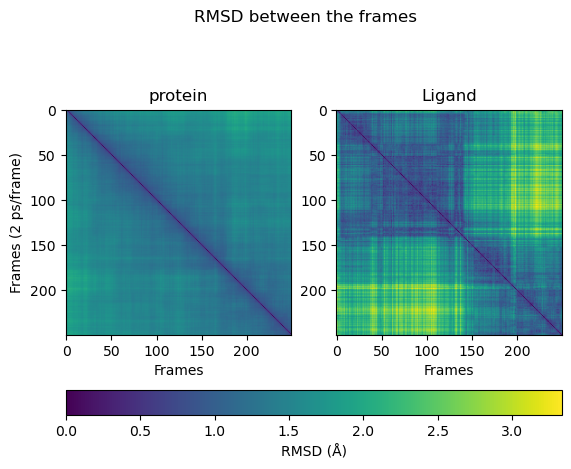

In [26]:
fig, ax = plt.subplots(1, 2)
fig.suptitle("RMSD between the frames")

# protein image
img1 = ax[0].imshow(dist_matrix_protein, cmap="viridis", vmin=0, vmax=max_dist)
ax[0].title.set_text("protein")
ax[0].set_xlabel("Frames")
ax[0].set_ylabel("Frames (2 ps/frame)")

# ligand image
img2 = ax[1].imshow(dist_matrix_ligand, cmap="viridis", vmin=0, vmax=max_dist)
ax[1].title.set_text("Ligand")
ax[1].set_xlabel("Frames")

fig.colorbar(img1, ax=ax, orientation="horizontal", fraction=0.1, label="RMSD (Å)");

### RMSF analysis
* https://userguide.mdanalysis.org/stable/examples/analysis/alignment_and_rms/rmsf.html
* The root-mean-square-fluctuation (RMSF) of a structure is the time average of the RMSD.


In [27]:
average = align.AverageStructure(md_universe, md_universe, select="protein and name CA", ref_frame=0).run()
# selecting protein and C_alpha atoms

In [28]:
ref = average.results.universe

In [29]:
aligner = align.AlignTraj(md_universe, ref, select="protein and name CA", in_memory=True).run()

In [30]:
c_alphas = md_universe.select_atoms("protein and name CA")
R = rms.RMSF(c_alphas).run()

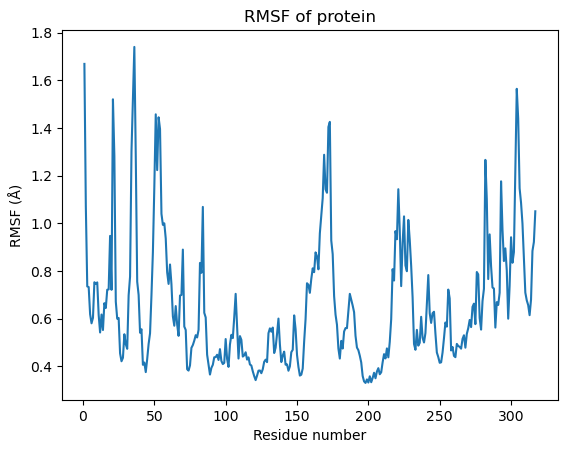

In [31]:
plt.plot(c_alphas.resids, R.results.rmsf)
plt.xlabel("Residue number")
plt.ylabel("RMSF (Å)")
plt.title("RMSF of protein");

### Interaction analysis
* We can analyze the interactions between the ligand and the protein to get an idea of the binding mode of the ligand.
* We can calculate the distances between the ligand and the protein residues to get an idea of the interactions that occur during the simulation.
* aroun 5 armstrong

In [32]:
# select pocket residues
pocket_resids = set(
    md_universe.select_atoms(f"(around 5 resname {ligand_name}) and protein").resids
)
view2 = nv.show_mdanalysis(md_universe)
view2.add_representation(
    "licorice", selection=f"protein and ({' '.join([str(x) for x in pocket_resids])})"
)
view2.center(selection="ligand")
view2.add_representation("bond", selection=f"resname {ligand_name}")
view2

NGLWidget(max_frame=249)

In [33]:
view2.render_image(trim=True, factor=2, transparent=True);
view2._display_image()

### Atomic distances
*  In this example, we want to look at the backbone nitrogen of methionine 793 coming in close contact with an aromatic ring of the ligand. 
* Theoretically, the distances can be calculated for groups of atoms, as long as each group has the same number of atoms, but we want to look at distances between single atoms. 
* Single atom selections can be done unambiguously with the combination of residue id and atom name inside that residue. 
* Residue names are not unique and thus are not be used here. 
* Atom names and their corresponding residue id can be accessed when hovering over the selected atom in the detailed view above.



In [34]:
protein_residue_id = "155"
protein_atom_name = "OD1"
ligand_id = "1"
ligand_atom_name = "H17x"

In [35]:
atomgroup_protein = md_universe.select_atoms(
    f"resid {protein_residue_id} and name {protein_atom_name}"
)
atomgroup_ligand = md_universe.select_atoms(f"resname {ligand_name} and name {ligand_atom_name}")


In [36]:
atomgroup_protein.atoms, atomgroup_ligand.atoms

(<AtomGroup with 1 atom>, <AtomGroup with 1 atom>)

In [37]:
distance = dist(atomgroup_protein, atomgroup_ligand)
print(
    f"The distance between residues {protein_residue_id} and {ligand_atom_name} of {ligand_name} is {distance[2][0]:.2f} Å"
)

The distance between residues 155 and H17x of UNK is 2.79 Å


In [38]:
distances = []
for _ in md_universe.trajectory:
    distance = dist(atomgroup_protein, atomgroup_ligand)
    distances.append(distance[2][0])

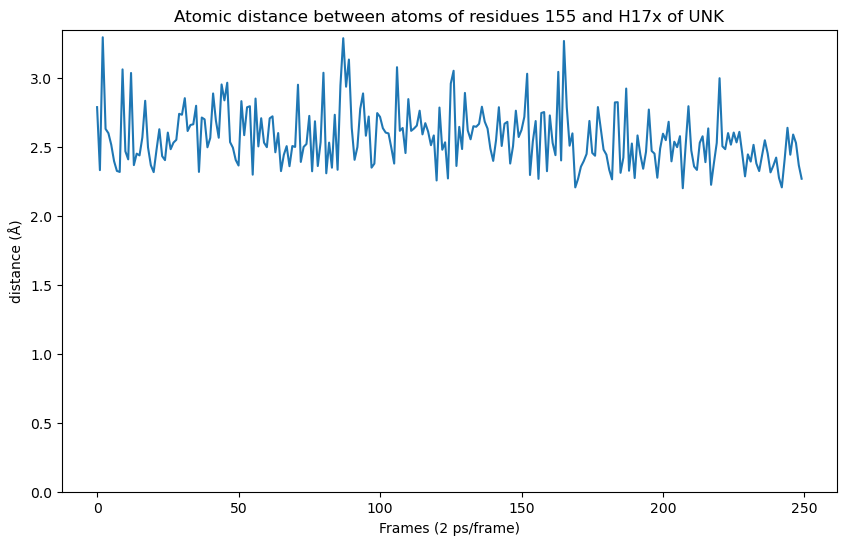

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(distances)
plt.gca().set_ylim(bottom=0)
plt.ylabel("distance (Å)")
plt.xlabel("Frames (2 ps/frame)")
plt.title(f"Atomic distance between atoms of residues {protein_residue_id} and {ligand_atom_name} of {ligand_name}")
plt.show()

### Hydrogen bond analysis
* As it happens, the interaction with the hinge region we are analyzing forms a hydrogen bond. 
* The nitrogen of the backbone from methionine is acting as the donor, the nitrogen in the aromatic ring of the ligand is the acceptor.

* We go back to the visualization to get the unique name of the hydrogen forming the bond.
* Then, we can use the hydrogen bond analysis capability from MDAnalysis to determine the characteristic distances and angles for the hydrogen bond. 
* The hydrogen bond analysis covers all frames without manual iteration and is convenient to plot.


In [51]:
hasattr(md_universe.atoms, 'charges')

False

In [58]:
md_universe.atoms

<AtomGroup with 52862 atoms>

In [50]:
md_universe.atoms.__dict__

{'_ix': array([    0,     1,     2, ..., 52859, 52860, 52861]),
 '_u': <Universe with 52862 atoms>,
 '_cache': {'isunique': True,
  'unsorted_unique': <AtomGroup with 52862 atoms>,
  'issorted': True,
  'sorted_unique': <AtomGroup with 52862 atoms>}}

In [41]:
h = HBA(universe=md_universe, between=["protein", "resname UNK"])
h.run(verbose=True)

NoDataError: This Universe does not contain charge information

In [ ]:
bond = pd.DataFrame(np.round(h.results.hbonds, 2))

In [ ]:
bond.head()

,0,1,2,3,4,5


In [ ]:
hasattr(md_universe.atoms, 'charges')

True

In [ ]:
hydrogen_name = "H"

In [ ]:
def run_hydrogenbond_analysis(
    universe,
    donor_resid,
    donor_atom,
    hydrogen_atom,
    acceptor_resid,
    acceptor_atom,
    h_cutoff=1.2,
    a_cutoff=3.0,
    angle_cutoff=120,
):
    """
    Perform an hydrogen bond analysis between selcted atom groups.
    Return the data as readable, formatted data frame.

    Parameters
    ----------
    universe: MDAnalysis.core.universe.Universe
        MDAnalysis universe.
    donor_resid: str
        Residue Id of residue containing donor atom in MDAnalysis universe.
    donor_atom: str
        Name of the donor atom in the MDAnalysis universe.
    hydrogen_atom: str
        Name of involved hydrogen atom in the MDAnalysis universe.
    acceptor_resid: str
        Residue Id of residue containing acceptor atom in the MDAnalysis universe.
    acceptor_atom: str
        Name of the acceptor atom in the MDAnalysis universe.
    h_cutoff: float, optional
        Distance cutoff used for finding donor-hydrogen pairs.
    a_cutoff: float, optional
        Donor-acceptor distance cutoff for hydrogen bonds.
    angle_cutoff: int, optional
        D-H-A angle cutoff for hydrogen bonds.

    Returns
    -------
    bond : pandas.core.frame.DataFrame
        DataFrame containing hydrogen bond information over time.
    """

    # set up and run the hydrogen bond analysis (HBA)
    hbonds = HBA(
        universe=universe,
        donors_sel="resid " + donor_resid + " and name " + donor_atom,
        hydrogens_sel="resid " + donor_resid + " and name " + hydrogen_atom,
        acceptors_sel="resid " + acceptor_resid + " and name " + acceptor_atom,
        d_h_cutoff=h_cutoff,
        d_a_cutoff=a_cutoff,
        d_h_a_angle_cutoff=angle_cutoff,
    )
    hbonds.run()
    # extract bond data
    bond = pd.DataFrame(np.round(hbonds.results.hbonds, 2))
    # name columns (according to MDAnalysis function description)
    bond.columns = [
        "frame",
        "donor_index",
        "hydrogen_index",
        "acceptor_index",
        "distance",
        "angle",
    ]
    # set frame as the index
    bond["frame"] = bond["frame"].astype(int)
    bond.set_index("frame", inplace=True, drop=True)
    return bond

In [ ]:
bond = run_hydrogenbond_analysis(
    md_universe, protein_residue_id, protein_atom_name, hydrogen_name, ligand_id, ligand_atom_name
)
bond.head()

/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 3.0 between Donor, resid 155 and name OD1, and Acceptor, resid 1 and name H17x.
  warnings.warn(
/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 120 between Donor, resid 155 and name OD1, and Acceptor, resid 1 and name H17x.
  warnings.warn(


,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,


In [ ]:
bond = run_hydrogenbond_analysis(
    md_universe,
    protein_residue_id,
    protein_atom_name,
    hydrogen_name,
    ligand_id,
    ligand_atom_name,
    a_cutoff=10.0,
)
bond.head()

/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:733: UserWarning: No hydrogen bonds were found given d-a cutoff of 10.0 between Donor, resid 155 and name OD1, and Acceptor, resid 1 and name H17x.
  warnings.warn(
/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:765: UserWarning: No hydrogen bonds were found given angle of 120 between Donor, resid 155 and name OD1, and Acceptor, resid 1 and name H17x.
  warnings.warn(


,donor_index,hydrogen_index,acceptor_index,distance,angle
frame,,,,,


In [82]:
view_strong = nv.show_mdanalysis(md_universe)
view_strong.add_representation("ball+stick", selection=f"protein and {protein_residue_id}")
view_strong.center(selection="ligand")
view_strong.frame = 71
view_strong

Exception ignored in: <function ReaderBase.__del__ at 0x70aee2a20550>
Traceback (most recent call last):
  File "/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/base.py", line 1532, in __del__
    self.close()
  File "/home/hyunsu/miniconda3/envs/openmm/lib/python3.10/site-packages/MDAnalysis/coordinates/XDR.py", line 186, in close
    self._xdr.close()
AttributeError: 'XTCReader' object has no attribute '_xdr'


NGLWidget(frame=71, max_frame=249)

In [83]:
view_bad = nv.show_mdanalysis(md_universe)
view_bad.add_representation("ball+stick", selection=f"protein and {protein_residue_id}")
view_bad.center(selection="ligand")
view_bad.frame = 1
view_bad

NGLWidget(frame=1, max_frame=249)